In [305]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
from scipy import stats as st
import re
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import probplot
from scipy.stats import shapiro

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [8]:
train.columns

Index(['id', '賃料', '所在地', 'アクセス', '間取り', '築年数', '方角', '面積', '所在階', 'バス・トイレ',
       'キッチン', '放送・通信', '室内設備', '駐車場', '周辺環境', '建物構造', '契約期間'],
      dtype='object')

In [7]:
train.describe()

,id,賃料
count,31470.000000,3.147000e+04
mean,15735.500000,1.182903e+05
std,9084.750822,7.374880e+04
min,1.000000,2.500000e+04
25%,7868.250000,7.600000e+04
50%,15735.500000,1.020000e+05
75%,23602.750000,1.360000e+05
max,31470.000000,2.500000e+06


In [6]:
train.head()

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間
3,4,150000,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。
4,5,74000,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間


In [187]:
re.search(r".+?線",train["アクセス"][0])
re.search(r"徒歩.+?分",train["アクセス"][1200])

<re.Match object; span=(9, 13), match='徒歩5分'>

In [189]:
print(train["アクセス"].str.contains("線").count())

31470


In [192]:
for i in range(31470):
    if not re.search(r".+?(線|ライン|ライナー)",train["アクセス"][i]):
        print(train["アクセス"][i])

つくばエクスプレス	八潮駅	徒歩18分		つくばエクスプレス	六町駅	徒歩31分
つくばエクスプレス	六町駅	徒歩14分
つくばエクスプレス	六町駅	徒歩9分
つくばエクスプレス	六町駅	徒歩14分
つくばエクスプレス	八潮駅	徒歩27分
つくばエクスプレス	八潮駅	徒歩15分
つくばエクスプレス	六町駅	徒歩13分
つくばエクスプレス	八潮駅	徒歩15分
ゆりかもめ	芝浦ふ頭駅	徒歩11分
つくばエクスプレス	八潮駅	徒歩21分
つくばエクスプレス	八潮駅	徒歩15分
つくばエクスプレス	六町駅	徒歩17分
つくばエクスプレス	六町駅	徒歩15分
つくばエクスプレス	六町駅	徒歩11分
つくばエクスプレス	青井駅	徒歩10分		つくばエクスプレス	六町駅	徒歩14分
つくばエクスプレス	六町駅	/バス(14分)樫の木公園前下車徒歩9分
つくばエクスプレス	八潮駅	徒歩15分
つくばエクスプレス	六町駅	徒歩12分
つくばエクスプレス	六町駅	徒歩9分
つくばエクスプレス	六町駅	徒歩16分
つくばエクスプレス	六町駅	徒歩16分		つくばエクスプレス	青井駅	徒歩19分
つくばエクスプレス	六町駅	徒歩16分
つくばエクスプレス	六町駅	徒歩7分
つくばエクスプレス	六町駅	徒歩10分
つくばエクスプレス	六町駅	徒歩8分		つくばエクスプレス	青井駅	徒歩12分
つくばエクスプレス	六町駅	徒歩15分
つくばエクスプレス	八潮駅	徒歩15分
つくばエクスプレス	六町駅	徒歩13分		つくばエクスプレス	青井駅	徒歩29分
つくばエクスプレス	六町駅	徒歩15分
つくばエクスプレス	六町駅	徒歩20分
つくばエクスプレス	六町駅	徒歩16分
つくばエクスプレス	六町駅	徒歩10分		つくばエクスプレス	青井駅	徒歩26分
つくばエクスプレス	六町駅	徒歩20分
つくばエクスプレス	六町駅	徒歩13分		つくばエクスプレス	青井駅	徒歩29分
つくばエクスプレス	六町駅	徒歩5分
つくばエクスプレス	六町駅	徒歩14分		つくばエクスプレス	青井駅	徒歩33分		つくばエクスプレス	八潮駅	徒歩34分
つくばエクスプレス	六町駅	徒歩14分
つくばエクスプレス	浅草(ＴＸ)駅	徒歩10分
つくばエクスプレス	六町駅	徒歩3分		つくばエクスプレス	青井駅	徒歩17分

In [12]:
for col in train.columns:
    if train[col].isnull().sum() > 0:
        print(col + " " + str(train[col].isnull().sum()))

方角 2749
バス・トイレ 329
キッチン 621
放送・通信 3440
室内設備 82
駐車場 5287
周辺環境 9432
契約期間 7120


In [13]:
print(train["面積"].str.contains("ms").count())

31470


In [14]:
print(train["築年数"].str.contains("月").count())

31470


In [360]:
train.groupby("建物構造").count()["id"]

建物構造
ALC（軽量気泡コンクリート）                  297
HPC（プレキャスト・コンクリート（重量鉄骨））           4
PC（プレキャスト・コンクリート（鉄筋コンクリート））       46
RC（鉄筋コンクリート）                   17505
SRC（鉄骨鉄筋コンクリート）                 2429
その他                              136
ブロック                               3
木造                              5512
軽量鉄骨                            1812
鉄骨造                             3726
Name: id, dtype: int64

In [362]:
train["建物構造"].unique()

array(['RC（鉄筋コンクリート）', '鉄骨造', '木造', 'SRC（鉄骨鉄筋コンクリート）', '軽量鉄骨',
       'ALC（軽量気泡コンクリート）', 'その他', 'PC（プレキャスト・コンクリート（鉄筋コンクリート））',
       'HPC（プレキャスト・コンクリート（重量鉄骨））', 'ブロック'], dtype=object)

In [389]:
train["方角"].unique()

array(['南東', nan, '南', '東', '北西', '西', '北', '南西', '北東'], dtype=object)

In [392]:
train.groupby("方角").count()["id"]

方角
北     1966
北東    1321
北西    1326
南     8909
南東    3098
南西    3080
東     4995
西     4026
Name: id, dtype: int64

In [393]:
temp1 = {"北":-2,"南":2,"":0}
temp2 = {"西":-1,"東":1,"":0}
hoge = {}

for key1 in temp1.keys():
    for key2 in temp2.keys():
        if key1 == "":
            hoge[key2] = temp2[key2]*2
        elif key2 == "":
            hoge[key1] = temp1[key1]*2
        else:
            key = key1+key2
            val = temp1[key1]+temp2[key2]
            val = val
            hoge[key] = val
print(hoge)


{'北西': -3, '北東': -1, '北': -4, '南西': 1, '南東': 3, '南': 4, '西': -2, '東': 2, '': 0}


In [ ]:
{'ブロック':0, '木造':0, 
 '軽量鉄骨':1,'鉄骨造':1,'ALC（軽量気泡コンクリート）':1,
 'RC（鉄筋コンクリート）':2,'SRC（鉄骨鉄筋コンクリート）':2, 'その他':2,
 'PC（プレキャスト・コンクリート（鉄筋コンクリート））':2,'HPC（プレキャスト・コンクリート（重量鉄骨））':2, }

In [48]:
test = "29年4ヶ月"

year = r"[0-9]+年"
month = r"[0-9]+ヶ月"

In [65]:
m = re.search(month,test)
print(m)
print(m[0])

<re.Match object; span=(3, 6), match='4ヶ月'>
4ヶ月


In [74]:
train.nunique()

id        31470
賃料          871
所在地       11333
アクセス      24172
間取り          30
築年数         746
方角            8
面積         5739
所在階        1032
バス・トイレ      360
キッチン        381
放送・通信       139
室内設備       6220
駐車場        3911
周辺環境      17864
建物構造         10
契約期間         66
dtype: int64

In [73]:
print(train["間取り"].unique())

['1K' '1R' '2LDK' '2DK' '1DK' '1LDK' '3LDK' '3DK' '1LDK+S(納戸)' '4K' '2K'
 '1K+S(納戸)' '4LDK' '3LDK+S(納戸)' '5LDK+S(納戸)' '5LDK' '3K' '4DK'
 '2LDK+S(納戸)' '2DK+S(納戸)' '4LDK+S(納戸)' '5DK' '3DK+S(納戸)' '1DK+S(納戸)' '5K'
 '6LDK' '2K+S(納戸)' '1LK+S(納戸)' '5DK+S(納戸)' '3K+S(納戸)']


In [77]:
temp = train["所在階"][0]

In [179]:
train["所在階"].unique()[:100]

array(['1階／12階建', '5階／10階建', '12階／15階建', '3階／4階建', '1階／2階建', '6階／12階建',
       '6階／8階建', '1階／6階建', '4階／9階建', '2階／3階建', '6階／10階建', '3階／3階建',
       '4階／11階建', '4階／5階建', '2階／5階建', '5階／11階建', '8階／12階建', '2階建',
       '7階／10階建', '10階／42階建', '2階／4階建', '12階／12階建', '2階／2階建', '10階／10階建',
       '1階／10階建', '4階／11階建（地下1階）', '3階／7階建', '4階／10階建', '8階／15階建',
       '2階／7階建（地下1階）', '3階／5階建', '3階／4階建（地下2階）', '1階／3階建', '4階／4階建',
       '7階／9階建', '11階／13階建', '4階／8階建', '6階／6階建', '1階／4階建', '11階／14階建',
       '13階／15階建', '9階／12階建', '3階／6階建', '地下4階／5階建', '10階／11階建', '7階／11階建',
       '2階／6階建', '5階／8階建', '6階／15階建', '／3階建', '5階／7階建', '8階／11階建',
       '4階／14階建', '5階／9階建', '8階／19階建', '／8階建', '12階／19階建', '5階／15階建',
       '3階／15階建', '3階／9階建', '1階／5階建', '7階／13階建', '9階／22階建', '9階／18階建',
       '2階／8階建', '12階／14階建', '12階／13階建', '2階／7階建', '1階／8階建',
       '2階／14階建（地下1階）', '5階／12階建（地下1階）', '3階建', '3階／13階建（地下2階）',
       '9階／10階建', '4階／6階建', '4階／13階建', '9階／13階建', '2階／12階建',
       '1階／3階建（地下1階）', '2階／11階建', '3階／14階建

In [367]:
kai =[]
takasa = []
for txt in train["所在階"].values:
    try:
        x,y = txt.split("／")
    except:
        continue
    try:
        x = int(re.search(r"[0-9]+",x)[0])
        y = int(re.search(r"[0-9]+",y)[0])
    except:
        continue
    kai.append(x)
    takasa.append(y)

In [378]:
kai = pd.DataFrame(kai)
kai.columns = ["hoge"]
takasa = pd.DataFrame(takasa)
takasa.columns = ["hoge"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x142a7a850>]],
      dtype=object)

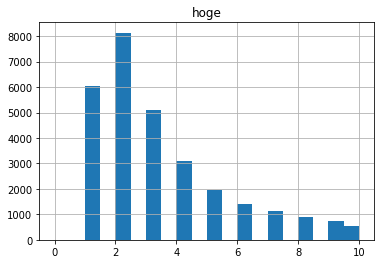

In [383]:
kai.hist(bins=20,range=(0,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1400c0d10>]],
      dtype=object)

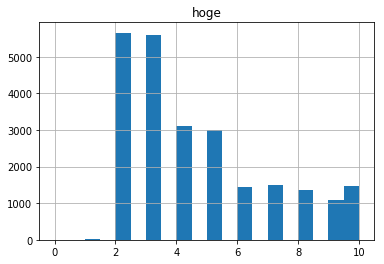

In [388]:
takasa.hist(bins=20,range=(0,10))

In [82]:
print(x)
print(y)

1階
12階建


In [89]:
train["アクセス"].str.contains("徒歩").count()

31470

In [103]:
p1 = ".+線.+駅.+分"
p2 = ".+線"
p3 = "線.+駅"
p4 = "徒歩.+分"
txt = train["アクセス"][0]

base = re.match(p1,txt)[0]
print(base)
print(re.match(p2,base))
print(re.search(p4,base))

都営三田線	西巣鴨駅	徒歩4分		埼京線	板橋駅	徒歩14分		都電荒川線	西ケ原四丁目駅	徒歩7分
<re.Match object; span=(0, 37), match='都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線'>
<re.Match object; span=(11, 50), match='徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\t西ケ原四丁目駅\t徒歩7分'>


In [104]:
print(train["アクセス"][345].split())

['京急本線', '梅屋敷(東京都)駅', '徒歩5分', '京急空港線', '京急蒲田駅', '徒歩13分', '京浜東北線', '蒲田駅', '徒歩19分']


In [88]:
m[0][3:-1]

'北'

In [95]:
train.groupby("方角").count()

,id,賃料,所在地,アクセス,間取り,築年数,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
方角,,,,,,,,,,,,,,,,
北,1966,1966,1966,1966,1966,1966,1966,1966,1952,1930,1803,1961,1682,1393,1966,1548
北東,1321,1321,1321,1321,1321,1321,1321,1321,1310,1309,1223,1321,1118,980,1321,1031
北西,1326,1326,1326,1326,1326,1326,1326,1326,1323,1317,1228,1325,1122,917,1326,1041
南,8909,8909,8909,8909,8909,8909,8909,8909,8850,8770,7868,8886,7441,6252,8909,6902
南東,3098,3098,3098,3098,3098,3098,3098,3098,3070,3043,2766,3091,2628,2124,3098,2435
南西,3080,3080,3080,3080,3080,3080,3080,3080,3058,3022,2768,3075,2585,2191,3080,2407
東,4995,4995,4995,4995,4995,4995,4995,4995,4953,4927,4531,4989,4247,3608,4995,3952
西,4026,4026,4026,4026,4026,4026,4026,4026,3983,3967,3660,4019,3405,2853,4026,3169


In [113]:
d = {}

for i in range(31470):
    if train["バス・トイレ"][i] != train["バス・トイレ"][i]:
        continue
    for key in train["バス・トイレ"][i].split():
        pat = "／"
        if re.sub(pat,"",key) not in d:
            d[re.sub(pat,"",key)] = 1
        else:
            d[re.sub(pat,"",key)] += 1
print(d)

{'専用バス': 23782, '専用トイレ': 23465, 'バス・トイレ別': 26458, 'シャワー': 28242, '浴室乾燥機': 16337, '': 15533, '温水洗浄便座': 17545, '洗面台独立': 20237, '脱衣所': 12361, '追焚機能': 11989, '共同トイレ': 86, 'バスなし': 141, '共同バス': 34}


In [150]:
d = {}

for i in range(31470):
    if train["キッチン"][i] != train["キッチン"][i]:
        continue
    for key in train["キッチン"][i].split():
        pat = "／"
        tmp = re.sub(pat,"",key)
        if re.match(r"コンロ設置可.*",tmp):
            tmp = "コンロ設置可"
        if tmp not in d:
            d[tmp] = 1
        else:
            d[tmp] += 1
print(d)

{'ガスコンロ': 20369, 'コンロ2口': 14947, 'システムキッチン': 20534, '': 26364, '給湯': 26368, '独立キッチン': 3907, 'コンロ3口': 5393, 'IHコンロ': 4431, 'コンロ1口': 3057, '冷蔵庫あり': 677, 'コンロ設置可': 2102, 'カウンターキッチン': 3724, 'L字キッチン': 309, '電気コンロ': 525, 'コンロ4口以上': 50}


In [152]:
l = {}
ind = 0
for key in d.keys():
    if key != "": 
        l[key] = ind
        ind += 1
print(l)

{'ガスコンロ': 0, 'コンロ2口': 1, 'システムキッチン': 2, '給湯': 3, '独立キッチン': 4, 'コンロ3口': 5, 'IHコンロ': 6, 'コンロ1口': 7, '冷蔵庫あり': 8, 'コンロ設置可': 9, 'カウンターキッチン': 10, 'L字キッチン': 11, '電気コンロ': 12, 'コンロ4口以上': 13}


In [138]:
key = "コンロ設置可（コンロ3口）"
pat = "／"
tmp = re.sub(pat,"",key)
# tmp = re.search(r"\（.+\）",tmp)
# print(tmp)
# print(tmp[0])
tmp = re.sub(r"\（.+\）","",tmp)
print(tmp)

コンロ設置可


In [153]:
d = {}

for i in range(31470):
    if train["室内設備"][i] != train["室内設備"][i]:
        continue
    for key in train["室内設備"][i].split():
        pat = "／"
        if re.sub(pat,"",key) not in d:
            d[re.sub(pat,"",key)] = 1
        else:
            d[re.sub(pat,"",key)] += 1
print(d)

{'エアコン付': 29746, 'シューズボックス': 22947, 'バルコニー': 25112, 'フローリング': 27274, '室内洗濯機置場': 27389, '敷地内ごみ置き場': 16746, '': 24588, 'エレベーター': 16148, '公営水道': 23242, '下水': 23415, '都市ガス': 25533, 'タイル張り': 13677, 'ウォークインクローゼット': 3848, '2面採光': 6636, '24時間換気システム': 10704, '3面採光': 1046, 'ペアガラス': 597, '専用庭': 215, '水道その他': 1685, '冷房': 5179, 'クッションフロア': 394, '床暖房': 1635, 'プロパンガス': 1010, 'ロフト付き': 1241, '出窓': 1314, 'トランクルーム': 504, '汲み取り': 5, 'オール電化': 549, 'ルーフバルコニー': 316, '室外洗濯機置場': 1695, '床下収納': 587, 'バリアフリー': 157, '浄化槽': 10, '防音室': 61, '二重サッシ': 87, '二世帯住宅': 3, 'ガスその他': 16, '洗濯機置場なし': 69, '排水その他': 9, '石油暖房': 1, '地下室': 7, 'ガス暖房': 2, '井戸': 1}


In [154]:
l = {}
ind = 0
for key in d.keys():
    if d[key] > 50 and key != "":
        l[key] = ind
        ind += 1
print(l)

{'エアコン付': 0, 'シューズボックス': 1, 'バルコニー': 2, 'フローリング': 3, '室内洗濯機置場': 4, '敷地内ごみ置き場': 5, 'エレベーター': 6, '公営水道': 7, '下水': 8, '都市ガス': 9, 'タイル張り': 10, 'ウォークインクローゼット': 11, '2面採光': 12, '24時間換気システム': 13, '3面採光': 14, 'ペアガラス': 15, '専用庭': 16, '水道その他': 17, '冷房': 18, 'クッションフロア': 19, '床暖房': 20, 'プロパンガス': 21, 'ロフト付き': 22, '出窓': 23, 'トランクルーム': 24, 'オール電化': 25, 'ルーフバルコニー': 26, '室外洗濯機置場': 27, '床下収納': 28, 'バリアフリー': 29, '防音室': 30, '二重サッシ': 31, '洗濯機置場なし': 32}


In [155]:
d = {}

for i in range(31470):
    if train["放送・通信"][i] != train["放送・通信"][i]:
        continue
    for key in train["放送・通信"][i].split():
        pat = "／"
        if re.sub(pat,"",key) not in d:
            d[re.sub(pat,"",key)] = 1
        else:
            d[re.sub(pat,"",key)] += 1
print(d)

{'インターネット対応': 17193, 'CATV': 13083, 'CSアンテナ': 9291, 'BSアンテナ': 13453, '光ファイバー': 16306, '高速インターネット': 2498, 'インターネット使用料無料': 5404, '有線放送': 72}


In [156]:
l = {}
ind = 0
for key in d.keys():
    if d[key] > 50 and key != "":
        l[key] = ind
        ind += 1
print(l)

{'インターネット対応': 0, 'CATV': 1, 'CSアンテナ': 2, 'BSアンテナ': 3, '光ファイバー': 4, '高速インターネット': 5, 'インターネット使用料無料': 6, '有線放送': 7}


In [167]:
d = {"無":0,"有":0}
place = [r"駐輪場\t",r"駐車場\t",r"バイク置き場\t"]
available = [r"空有",r"[(無)|(近隣)|(空無)]"]
all_pat = []

for p in place:
    for a in available:
        all_pat.append(p+a)
exist = all_pat[::2]
dont = all_pat[1::2]
print(exist)
print(dont)


for i in range(31470):
    if train["駐車場"][i] != train["駐車場"][i]:
        continue
    for pat in exist:
        if re.search(pat,train["駐車場"][i]):
            d["有"]　+= 1
        else:
            d["無"]　+= 1
print(d)

['駐輪場\\t空有', '駐車場\\t空有', 'バイク置き場\\t空有']
['駐輪場\\t[(無)|(近隣)|(空無)]', '駐車場\\t[(無)|(近隣)|(空無)]', 'バイク置き場\\t[(無)|(近隣)|(空無)]']
{'駐輪場\t空有': 16490, '駐輪場\t空': 16505, '駐車場\t無': 8597, 'バイク置き場\t無': 12642, '駐車場\t近': 6627, 'バイク置き場\t空有': 5096, 'バイク置き場\t空': 5143, '駐輪場\t無': 4513, '駐車場\t空有': 5738, '駐車場\t空': 6193, 'バイク置き場\t近': 173, '駐輪場\t近': 2}


In [173]:
d = [0 for i in range(6)]
exist = [r"駐輪場\t空有",r"駐車場\t空有",r"バイク置き場\t空有"]
# available = [r"空有",r"[(無)|(近隣)|(空無)]"]
# all_pat = []

# for p in place:
#     for a in available:
#         all_pat.append(p+a)
# exist = all_pat[::2]
# dont = all_pat[1::2]
# print(exist)
# print(dont)


for i in range(31470):
    if train["駐車場"][i] != train["駐車場"][i]:
        continue
    for j in range(len(exist)):
        if re.search(exist[j],train["駐車場"][i]):
            d[j] += 1
        else:
            d[j+3] += 1
print(d)

[16490, 5738, 5096, 9693, 20445, 21087]


In [174]:
d = {}

for i in range(31470):
    if train["周辺環境"][i] != train["周辺環境"][i]:
        continue
    for key in train["周辺環境"][i].split():
        pat = "／"
        p2 = "【.*】"
        if re.match(p2,key):
            if re.sub(pat,"",key) not in d:
                d[re.sub(pat,"",key)] = 1
            else:
                d[re.sub(pat,"",key)] += 1
print(d)

{'【小学校】': 2655, '【大学】': 2052, '【公園】': 3807, '【飲食店】': 6929, '【スーパー】': 40666, '【コンビニ】': 34944, '【ドラッグストア】': 5594, '【郵便局】': 3478, '【病院】': 3804, '【図書館】': 1299, '【銀行】': 1267, '【学校】': 1551, '【幼稚園・保育園】': 1824, '【総合病院】': 1890, '【デパート】': 691, '【レンタルビデオ】': 502, '【クリーニング】': 146, '【コインパーキング】': 22, '【月極駐車場】': 2}


In [176]:
l = {}
ind = 0
for key in d.keys():
    if d[key] > 50 and key != "":
        l[key] = ind
        ind += 1
print(l)

{'【小学校】': 0, '【大学】': 1, '【公園】': 2, '【飲食店】': 3, '【スーパー】': 4, '【コンビニ】': 5, '【ドラッグストア】': 6, '【郵便局】': 7, '【病院】': 8, '【図書館】': 9, '【銀行】': 10, '【学校】': 11, '【幼稚園・保育園】': 12, '【総合病院】': 13, '【デパート】': 14, '【レンタルビデオ】': 15, '【クリーニング】': 16}


In [275]:
Q1 = train["賃料"].quantile(.25)
Q3 = train["賃料"].quantile(.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR
print(threshold)
print(train.query("賃料>500000").describe())

226000.0
                 id            賃料
count    124.000000  1.240000e+02
mean   15297.314516  7.521089e+05
std     8840.773142  2.938759e+05
min      275.000000  5.050000e+05
25%     7486.000000  5.572500e+05
50%    16608.500000  6.500000e+05
75%    22014.000000  8.425000e+05
max    31116.000000  2.500000e+06


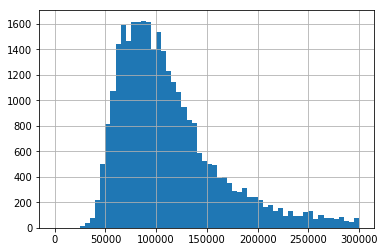

In [293]:
train["賃料"].hist(bins=60,range=(0,300000))

(array([   3.,    2.,    9.,   12.,   15.,    9.,   15.,   30.,   35.,
         128.,   88.,  193.,  307.,  321.,  487.,  666.,  833.,  799.,
        1257.,  996., 1003., 1336., 1342., 1317., 1624., 1463., 1438.,
        1560., 1547., 1351., 1544., 1073., 1102., 1017.,  654.,  871.,
         668.,  491.,  593.,  483.]),
 array([10.1266311 , 10.17855456, 10.23047802, 10.28240148, 10.33432494,
        10.38624841, 10.43817187, 10.49009533, 10.54201879, 10.59394225,
        10.64586571, 10.69778917, 10.74971263, 10.80163609, 10.85355955,
        10.90548301, 10.95740647, 11.00932993, 11.06125339, 11.11317685,
        11.16510031, 11.21702377, 11.26894723, 11.32087069, 11.37279415,
        11.42471761, 11.47664107, 11.52856453, 11.58048799, 11.63241145,
        11.68433491, 11.73625837, 11.78818183, 11.84010529, 11.89202875,
        11.94395221, 11.99587567, 12.04779913, 12.09972259, 12.15164606,
        12.20356952]),
 <a list of 40 Patch objects>)

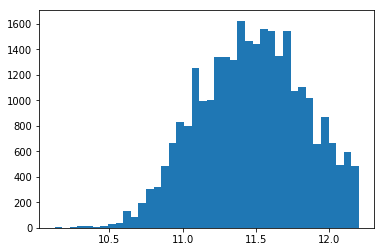

In [342]:
temp = train.query("賃料<200000")["賃料"].values
temp = np.log(temp)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(temp,bins = 40)

((array([-3.06048692, -2.78433842, -2.62947664, -2.51987722, -2.43413287,
         -2.36324986, -2.30256398, -2.24933289, -2.20180251, -2.15878052,
         -2.11941826, -2.08308943, -2.04931821, -2.01773425, -1.98804347,
         -1.9600083 , -1.933434  , -1.90815881, -1.88404691, -1.86098307,
         -1.83886868, -1.81761864, -1.79715902, -1.77742516, -1.75836014,
         -1.73991361, -1.72204082, -1.70470176, -1.68786056, -1.67148492,
         -1.65554561, -1.64001615, -1.62487242, -1.61009241, -1.59565599,
         -1.58154466, -1.56774141, -1.55423056, -1.54099761, -1.52802914,
         -1.51531267, -1.50283663, -1.49059022, -1.47856336, -1.46674665,
         -1.45513127, -1.44370895, -1.43247195, -1.42141298, -1.41052516,
         -1.39980203, -1.38923749, -1.37882576, -1.36856139, -1.35843922,
         -1.34845435, -1.33860214, -1.32887817, -1.31927826, -1.30979841,
         -1.30043483, -1.29118391, -1.28204218, -1.27300635, -1.26407328,
         -1.25523996, -1.24650352, -1.

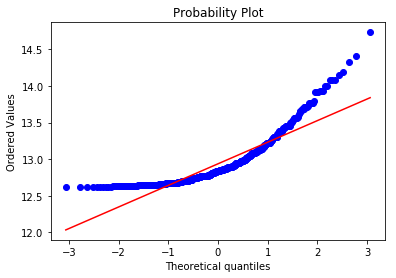

In [400]:
temp = train.query("賃料>300000")["賃料"].values
temp = np.log(temp)
probplot(temp,dist="norm",plot=plt)

In [401]:
w,p = shapiro(temp)
print(w,p)
if p < 0.05:
    print("not norm")
else:
    print("norm")

0.8149043321609497 3.217715253036304e-26
not norm


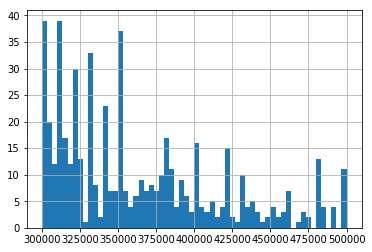

In [294]:
train["賃料"].hist(bins=60,range=(300000,500000))

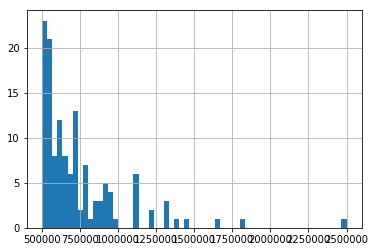

In [292]:
train["賃料"].hist(bins=60,range=(500000,2500000))

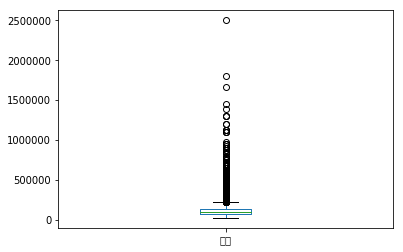

In [224]:
train["賃料"].plot.box()

(array([1.000e+01, 1.900e+01, 3.500e+01, 6.500e+01, 2.170e+02, 5.040e+02,
        1.133e+03, 1.668e+03, 2.538e+03, 2.615e+03, 2.967e+03, 3.324e+03,
        3.549e+03, 3.088e+03, 2.571e+03, 1.675e+03, 1.473e+03, 1.193e+03,
        8.550e+02, 5.650e+02, 5.780e+02, 2.790e+02, 1.860e+02, 1.050e+02,
        7.700e+01, 4.800e+01, 4.200e+01, 1.900e+01, 2.600e+01, 1.300e+01,
        7.000e+00, 1.000e+01, 3.000e+00, 5.000e+00, 4.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([10.1266311 , 10.24176036, 10.35688961, 10.47201887, 10.58714812,
        10.70227738, 10.81740663, 10.93253589, 11.04766514, 11.1627944 ,
        11.27792365, 11.3930529 , 11.50818216, 11.62331141, 11.73844067,
        11.85356992, 11.96869918, 12.08382843, 12.19895769, 12.31408694,
        12.4292162 , 12.54434545, 12.65947471, 12.77460396, 12.88973322,
        13.00486247, 13.11999172, 13.23512098, 13.35025023, 13.46537949,
        13.58050874, 13.695638  , 13.81076725, 13.92589651, 14.0

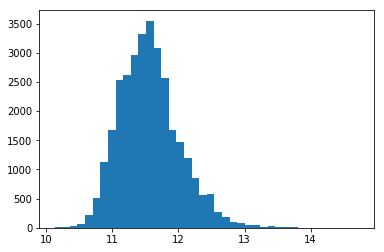

In [201]:
temp = train["賃料"].values
temp = np.log(temp)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(temp,bins = 40)

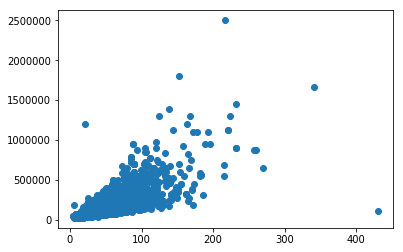

In [353]:

class parse_area_size:
    def __init__(self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        hoge = x.copy()
        temp = x["面積"].values
        ans = [0 for i in range(len(temp))]
        for i in range(len(temp)):
            ans[i] = float(re.search(r"[0-9\.]+",temp[i])[0])
        hoge = hoge.drop("面積",axis = 1)
        hoge = hoge.assign(areasize=ans)
        return hoge
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
test = parse_area_size()
hoge = test.transform(train)
ax.scatter(hoge["areasize"],hoge["賃料"])

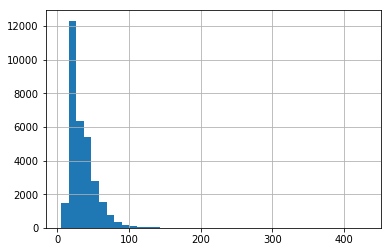

In [355]:
hoge["areasize"].hist(bins=40)

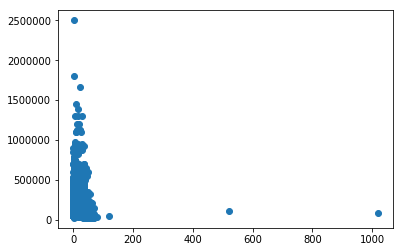

In [208]:
class parse_how_old:
    def __init__(self):
        self.year_pat = re.compile(r"[0-9]+年")
        self.month_pat = re.compile(r"[0-9]+ヶ月")
    def fit(self,x,y):
        return self
    def transform(self,x):
        hoge = x.copy()
        temp = x["築年数"].values
        add_year = [0 for i in range(len(temp))]
        add_month = [0 for i in range(len(temp))]
        for i in range(len(temp)):
            year = self.year_pat.search(temp[i])
            month = self.month_pat.search(temp[i])
            if year:
                year = year[0][:-1]
            else:
                year = 0
            if month:
                month = month[0][:-2]
            else:
                month = 0
            add_year[i] = int(year)
            add_month[i] = int(month)
        hoge = hoge.drop(["築年数"],axis = 1)
        hoge  = hoge.assign(year=add_year)
        hoge = hoge.assign(month= add_month)
        return hoge
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
test = parse_how_old()
hoge = test.transform(train)
ax.scatter(hoge["year"],hoge["賃料"])

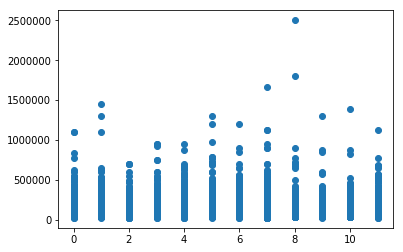

In [212]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
test = parse_how_old()
hoge = test.transform(train)
ax.scatter(hoge["month"],hoge["賃料"])

,count,mean,std,min,25%,50%,75%,max
is_teiki,,,,,,,,
0,29799.0,114413.141112,62814.566128,25000.0,75000.0,100000.0,133000.0,1203500.0
1,1671.0,187431.927588,164420.531211,27000.0,100500.0,157000.0,226000.0,2500000.0


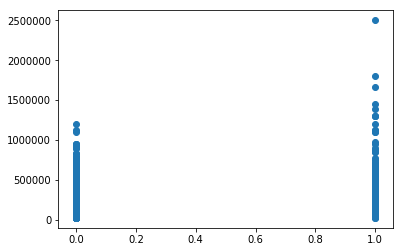

In [258]:
class parse_contract_time:
    def __init__(self):
        self.teiki_pat = re.compile(r".*\t.*")
        self.year_pat = re.compile(r"[0-9]+年間")
        self.month_pat = re.compile(r"[0-9]+ヶ月間")
        self.due_year_pat = re.compile(r"[0-9]+年")
        self.due_month_pat = re.compile(r"[0-9]+月まで")
        self.double_pat = re.compile(r"[0-9]+年[0-9]+ヶ月間")
    def fit(self,x,y):
        return self
    def transform(self,x):
        hoge = x.copy()
        temp = x["契約期間"].values
        isteiki = [0 for i in range(len(temp))]
        add_year = [0 for i in range(len(temp))]
        add_month = [0 for i in range(len(temp))]
        for i in range(len(temp)):
            if not temp[i] == temp[i]:
                add_year[i] = 2
                add_month[i] = 0   
                continue
            if self.teiki_pat.match(temp[i]):
                isteiki[i] = 1
            if self.double_pat.match(temp[i]):
                year = self.due_year_pat.search(temp[i])[0][:-1]
                month = self.month_pat.search(temp[i])[0][:-3]
                add_year[i] = int(year)
                add_month[i] = int(month)
            else:
                if self.due_month_pat.search(temp[i]):
                    year = self.due_year_pat.search(temp[i])[0][:-1]
                    month = self.due_month_pat.search(temp[i])[0][:-3]
                    year = int(year)-2019
                    month = int(month)-9
                    if month < 0:
                        year -= 1
                        month += 12
                    add_year[i] = int(year)
                    add_month[i] = int(month)
                else:
                    if self.year_pat.match(temp[i]):
                        year = self.year_pat.match(temp[i])[0][:-2]
                        month = 0
                    else:
                        year = 0
                        month = self.month_pat.match(temp[i])[0][:-3]
                    add_year[i] = int(year)
                    add_month[i] = int(month)
        hoge = hoge.drop(["契約期間"],axis = 1)
        hoge = hoge.assign(is_teiki=isteiki)
        hoge = hoge.assign(cont_year= add_year)
        hoge = hoge.assign(cont_month= add_month)
        return hoge

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
test = parse_contract_time()
hoge = test.transform(train)
ax.scatter(hoge["is_teiki"],hoge["賃料"])
hoge.groupby("is_teiki")["賃料"].describe()

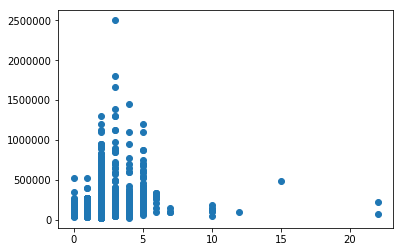

In [217]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
test = parse_contract_time()
hoge = test.transform(train)
ax.scatter(hoge["cont_year"],hoge["賃料"])

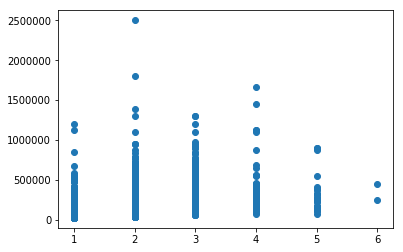

In [218]:
class parse_rooms:
    def __init__(self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        hoge = x.copy()
        temp = x["間取り"].values
        room = [0 for i in range(len(temp))]
        head = ["R","L","D","K","S"]
        setubi = [[0 for i in range(len(temp))] for j in range(5)]
        for i in range(len(temp)):
            room[i] = int(temp[i][0])
            for j in range(5):
                if head[j] in temp[i]:
                    setubi[j][i] = 1
        hoge = hoge.drop("間取り",axis = 1)
        hoge = hoge.assign(room = room)
        hoge = hoge.assign(R = setubi[0])
        hoge = hoge.assign(L = setubi[1])
        hoge = hoge.assign(D = setubi[2])
        hoge = hoge.assign(K = setubi[3])
        hoge = hoge.assign(S = setubi[4])
        return hoge
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
test = parse_rooms()
hoge = test.transform(train)
ax.scatter(hoge["room"],hoge["賃料"])

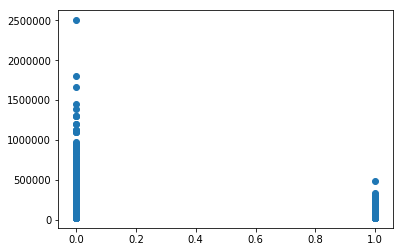

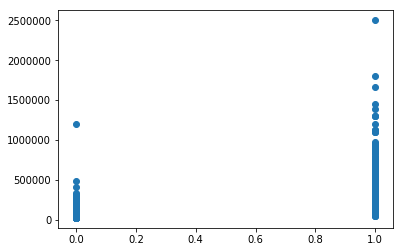

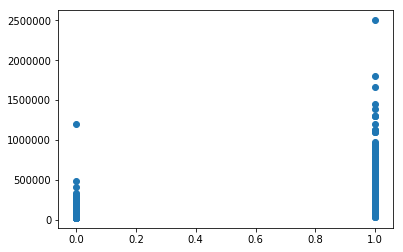

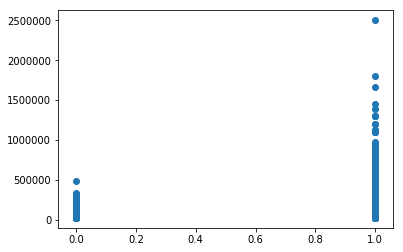

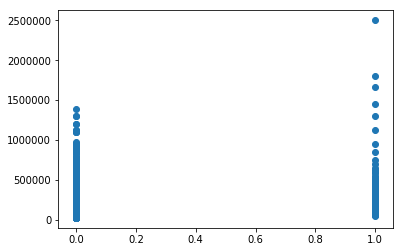

In [221]:
temp = ["R","L","D","K","S"]
for t in temp:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    test = parse_rooms()
    hoge = test.transform(train)
    ax.scatter(hoge[t],hoge["賃料"])

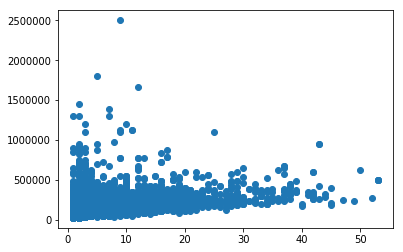

In [222]:
class height_encoder:
    def __init__ (self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        fuga = x.copy()
        tmp = x["所在階"].values
        where = [0 for i in range(len(tmp))]
        what = [0 for i in range(len(tmp))]
        for i in range(len(tmp)):
            hoge =  tmp[i].split("／")
            if len(hoge) == 2:
                if hoge[0] == "":
                    hoge[0] = "2階"
                if hoge[1] == "":
                    hoge[1] = "5階建て"
                x = int(re.search(r"[0-9]+",hoge[0])[0])
                y = int(re.search(r"[0-9]+",hoge[1])[0])
            else:
                x = 2
                y = 3
            where[i] = x
            what[i] = y
        fuga = fuga.drop("所在階",axis = 1)
        fuga = fuga.assign(what_floor=where)
        fuga = fuga.assign(height_bld=what)
        return fuga
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
test = height_encoder()
hoge = test.transform(train)
ax.scatter(hoge["what_floor"],hoge["賃料"])

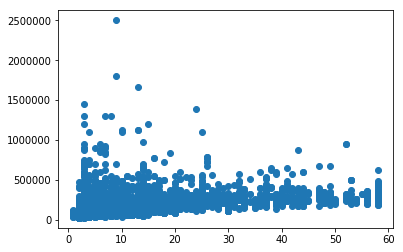

In [223]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
test = height_encoder()
hoge = test.transform(train)
ax.scatter(hoge["height_bld"],hoge["賃料"])

        count           mean           std      min      25%       50%  \
dir0                                                                     
0.0   29504.0  117772.716411  73853.049925  25000.0  75750.0  101000.0   
1.0    1966.0  126057.842319  71737.317201  28000.0  85000.0  109000.0   

           75%        max  
dir0                       
0.0   136000.0  2500000.0  
1.0   141000.0  1300000.0  
        count           mean           std      min      25%       50%  \
dir1                                                                     
0.0   30149.0  117885.999934  73344.254107  25000.0  76000.0  101000.0   
1.0    1321.0  127517.737320  81933.836474  28000.0  87000.0  108000.0   

           75%        max  
dir1                       
0.0   136000.0  2500000.0  
1.0   141000.0  1300000.0  
        count           mean           std      min      25%       50%  \
dir2                                                                     
0.0   30144.0  117520.432458  7300

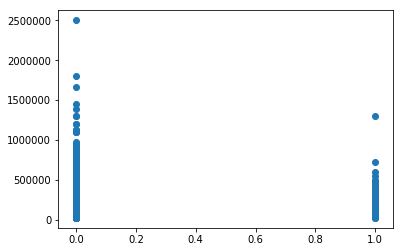

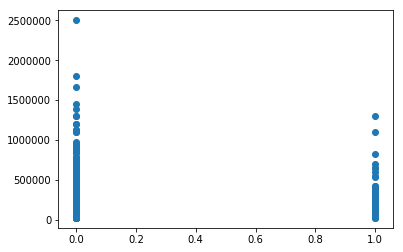

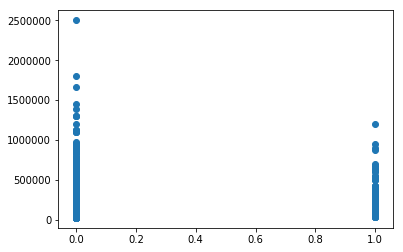

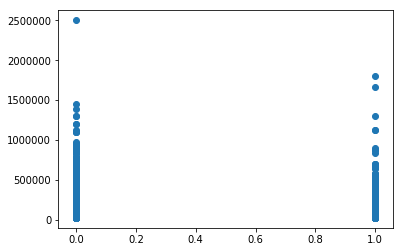

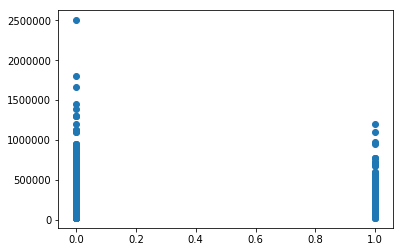

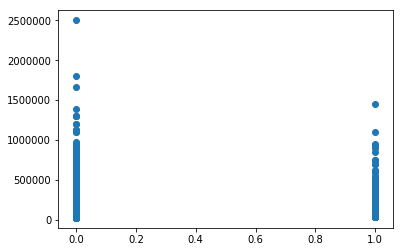

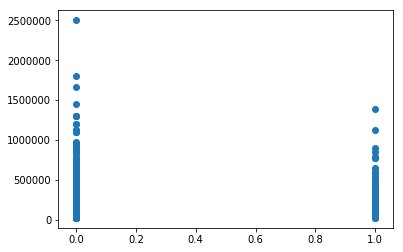

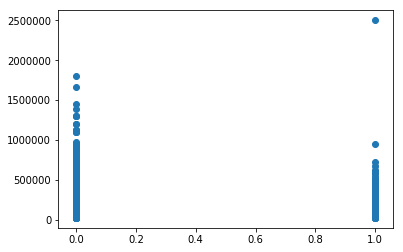

In [256]:
class direction_encoder:
    def __init__(self):
        self.encoder = OneHotEncoder(sparse=False,handle_unknown="ignore")
    def fit(self,x,y):
        self.encoder.fit(x["方角"].fillna("南").values.reshape(-1,1))
        return self
    def transform(self,x):
        tmp = x["方角"]
        tmp = tmp.fillna("南")
        tmp = pd.DataFrame(self.encoder.transform(tmp.values.reshape(-1,1)))
        c_num = len(tmp.columns)
        col = []
        for i in range(c_num):
            col.append("dir"+str(i))
        tmp.columns = col
        hoge = x.drop("方角",axis = 1)
        tmp.index = hoge.index
        return pd.concat([hoge,tmp],axis = 1)
    

for i in range(8):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    test = direction_encoder()
    test.fit(train,test)
    hoge = test.transform(train)
    ax.scatter(hoge["dir"+str(i)],hoge["賃料"])
    print(hoge.groupby("dir"+str(i))["賃料"].describe())

In [ ]:
class direction_encoder:
    def __init__(self):
        self.encoder = OneHotEncoder(sparse=False,handle_unknown="ignore")
    def fit(self,x,y):
        self.encoder.fit(x["方角"].fillna("南").values.reshape(-1,1))
        return self
    def transform(self,x):
        tmp = x["方角"]
        tmp = tmp.fillna("南")
        tmp = pd.DataFrame(self.encoder.transform(tmp.values.reshape(-1,1)))
        c_num = len(tmp.columns)
        col = []
        for i in range(c_num):
            col.append("dir"+str(i))
        tmp.columns = col
        hoge = x.drop("方角",axis = 1)
        tmp.index = hoge.index
        return pd.concat([hoge,tmp],axis = 1)
    

for i in range(8):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    test = direction_encoder()
    test.fit(train,test)
    hoge = test.transform(train)
    ax.scatter(hoge["dir"+str(i)],hoge["賃料"])
    print(hoge.groupby("dir"+str(i))["賃料"].describe())